In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display

# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

C:\Users\albin\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)

test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]
df.drop(['Date'], axis=1, inplace=True)
# df = df.iloc[:,0:5]

n_features = df.shape[1]-1

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

c:\Users\albin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\albin\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3382: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if await self.run_code(code, result, async_=asy):


In [13]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.1)
val_size = int(len(df) * 0.2)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
val_df = df[val_end-val_size:val_end]
test_df = df[test_end-test_size:test_end]
train_df = pd.concat([train_df, df[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(142016, 470)
(40575, 470)
(20287, 470)


In [14]:
# Define the sequence length for the LSTM model
sequence_length = 10

def create_sequences(df, sequence_length):
    X = []
    y = []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length, 1:].values)
        y.append(df.iloc[i+sequence_length, 0])
    return np.array(X), np.array(y)


X_train, y_train = create_sequences(train_df, sequence_length)
X_val, y_val = create_sequences(val_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(142006, 10, 469)
(40565, 10, 469)
(20277, 10, 469)


In [15]:
batch_size = 128
print(y_val.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train, :, :]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val, :, :]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test, :, :]
y_test = y_test[:num_samples_test]

# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(40565,)


(141952,)


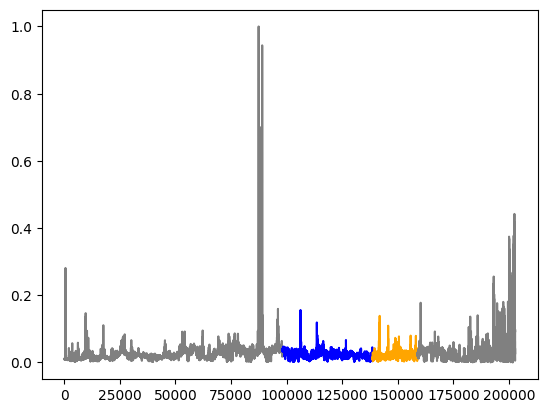

In [16]:
print(y_train.shape)
plt.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color='grey')
plt.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color='blue')
plt.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color='orange')
plt.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color='grey')

In [17]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, sequence_length, n_features), return_sequences=True, stateful=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Normalization(),
    tf.keras.layers.LSTM(32, batch_input_shape=(batch_size, sequence_length, n_features), stateful=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


In [18]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [19]:

def compile_and_fit(model, X_train, y_train, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  print(model.summary())
  model.reset_states()
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=batch_size, verbose=1,
                      callbacks=[early_stopping, PlotLearning()])
  return history

In [20]:

history = compile_and_fit(model, X_train, y_train)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (128, 10, 469)            1761564   
                                                                 
 dropout_2 (Dropout)         (128, 10, 469)            0         
                                                                 
 normalization_1 (Normalizat  (128, 10, 469)           939       
 ion)                                                            
                                                                 
 lstm_3 (LSTM)               (128, 469)                1761564   
                                                                 
 dropout_3 (Dropout)         (128, 469)                0         
                                                                 
 dense_1 (Dense)             (128, 1)                  470       
                                                      

KeyboardInterrupt: 

In [ ]:
result = model.predict(X_test)

634/634 [==============================] - 17s 25ms/step


(20277, 1)
[[0.01964929]
 [0.01921749]
 [0.0191454 ]
 ...
 [0.02138635]
 [0.02140702]
 [0.02104482]]


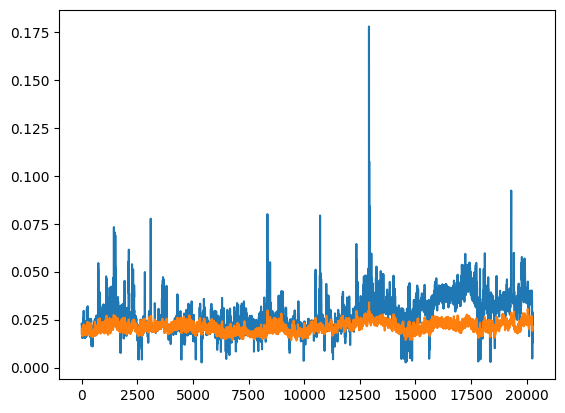

In [ ]:

print(result.shape)
print(result)
plt.plot(y_test)
plt.plot(result)